In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime # convert string to datetime

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose # decompose seasonality

## Section 1: Time Series (continued from Lab)

### Preparation

In [2]:
alcohol_data = pd.read_csv("../W9/Alcohol_Sales.csv")
alcohol_data["DATE"] =  [datetime.strptime(x, '%B-%y') for x in alcohol_data["DATE"]]
alcohol = alcohol_data.set_index("DATE")
alcohol.head()

,units_sold
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


### 1. From the lab, we saw the series had non-constant variance. Transform the data to address this.

In [3]:
# take log of sales to lower the rate at which rolling mean increases
sales_log = np.log(alcohol["units_sold"])
sales_log = pd.DataFrame(data = sales_log, columns = ["units_sold"])
#sales_log_shift = sales_log - sales_log.shift()
#sales_log_shift.dropna(inplace=True)
#sales_log_shift = pd.DataFrame(data = sales_log_shift, columns = ["units_sold"])

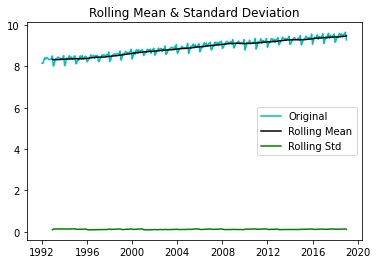

In [4]:
# rolling statistics 
rolling_mean = sales_log.rolling(window=12).mean() 
rolling_std = sales_log.rolling(window=12).std() 
    
# rolling statistics plot 
original = plt.plot(sales_log, color='c', label='Original') 
mean = plt.plot(rolling_mean, color='k', label='Rolling Mean') 
std = plt.plot(rolling_std, color='g', label='Rolling Std') 

plt.legend(loc='best') 
plt.title('Rolling Mean & Standard Deviation') 
plt.show(block=False) 

*With log-transformation, the variance becomes constant. The mean, however, is still growing.*

### 2. Decompose transformed outcome into trend, seasonal, & residual components

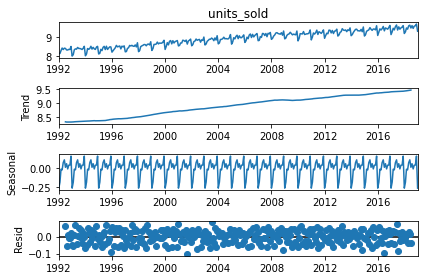

In [5]:
decompose = seasonal_decompose(sales_log["units_sold"])
decompose.plot()
plt.show()

### 3. Use the auto-ARIMA function to determine how many seasonal and non-seasonal AR lags, differences, or MA components are needed for the best fitting model on the transformed outcome.

In [6]:
from pmdarima import auto_arima

In [7]:
# code from https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/
stepwise_fit = auto_arima(sales_log["units_sold"], 
                          start_p = 1, start_q = 1,
                          max_p = 12, max_q = 12, max_d = 12, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, trace = True,
                          stepwise = True)           # set to stepwise
# D = 1
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-734.194, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-271.971, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-729.842, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-273.814, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-437.439, Time=0.22 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-1024.448, Time=1.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-1027.096, Time=0.72 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-1024.948, Time=2.13 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=-1023.138, Time=2.25 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-1012.009, Time=0.88 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-1081.908, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-438.684, Time=0.32 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=-1085.172, Time=2.54 sec
 ARIMA(2,1,1)(2,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  325
Model:             SARIMAX(3, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 574.342
Date:                                 Tue, 01 Nov 2022   AIC                          -1128.685
Time:                                         18:12:38   BIC                          -1090.878
Sample:                                     01-01-1992   HQIC                         -1113.594
                                          - 01-01-2019                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.038e-05   5.46e-05      0.373      0.709   -8.66e-05       0.000
ar.L1         -0.5163      0.308     -1.678      0.093      -1.119       0.087
ar.L2         -0.1789      0.346     -0.517      0.605      -0.858       0.500
ar.L3          0.4420      0.265      1.668      0.095      -0.077       0.961
ma.L1         -0.6676      0.294     -2.274      0.023      -1.243      -0.092
ar.S.L12       0.1575      0.449      0.351      0.726      -0.722       1.037
ar.S.L24       0.8357      0.447      1.871      0.061      -0.040       1.711
ma.S.L12       0.1317      0.425      0.310      0.757      -0.701       0.965
ma.S.L24      -0.6445      0.295     -2.183      0.029      -1.223      -0.066
sigma2         0.0015      0.000     11.513      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                13.44
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.21
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4. What did the function find was the best fitting model? Explain what components it recommended.

*The best model find is ARIMA(3,1,1)(2,0,2)[12], which is actually a seasonal model.*
- *__p__ represents the number of AR lags used to predict current values. The function found 3 as the best number of lags, meaning that it is best to use three previous values to predict the current value.*  
- *__d__ is the degree of distance. d = 1 means that the amount of differencing to be performed on the series to make it stationary is 1. In other words, we will subtract the previous time points to create new data points, in which $𝑦_𝑡$′ = $𝑦_𝑡$ − $𝑦_{𝑡 −1}$.*  
- *__q__ is the number of MA components (errors). q = 1 means that the current value is correlated to one previous residual.*  
- *__P__, __D__, and __Q__ are the seasonal AR lags, differncing degree, and MA components. In the best fitting model, these parameters are set to be 2, 0, and 2, respectively.*  
- *__S__ is the the number of time units for the cycle. In this best model, S is set to be 12 (via the m parameter), due to the fact that sales data was recorded in months and every 12 months is a sales cycle.*

## Section 2: Poisson Regression

In [8]:
import math
import numpy as np
import seaborn as sns
import pandas as pd

In [9]:
complication = pd.read_csv("../W9/ERdatOK.csv")
complication.head()

,Patients,Complication,Residency,Sex,RevPerHour,HoursService
0,1661,0,N,M,260.92,877.25
1,879,1,Y,M,206.42,705.25
2,1029,1,Y,F,287.76,1289
3,1486,1,Y,F,277.78,933.95
4,1780,1,N,M,236.32,1005.5


### 1. Answer the following:
**a. What is the outcome?**  
*Complication, or the count of complications (per patient if offset by Patients) that night.*  
**b. What are the predictors they want to understand the impact of?**  
*Number of patients, whether the attending physician was a resident, gender of the physician, revenue per hour of the ER that evening, and the number of hours of service the attending physician has had at this ER.*  
**c. What is the hypothesis?**  
*The hypothesis is that the count of complication that night changes as the predictors listed above change, or at least one coefficient of the above predictors is not 0.*  
*The null hypothesis would be that count of complication does not change as the predictors change, or all coefficients of the above predictors are 0.*

### 2. Check whether the outcome is Poisson.

In [10]:
complication["Complication"].value_counts()

1     12
2     12
3      5
5      4
6      2
7      2
8      2
0      1
4      1
9      1
10     1
11     1
Name: Complication, dtype: int64

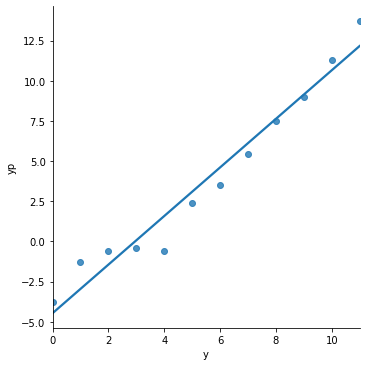

In [11]:
def poissonness_plot(y_val):
    df = pd.DataFrame(y_val.value_counts())
    df.reset_index(inplace=True)
    df.columns = ['y', 'cnt']
    df['fact'] = 0
    N = df.cnt.sum()
    for i, f in enumerate(df.y):
        df.fact[i] = math.factorial(f)
    df['yp'] = np.log((df.fact*df.cnt)/N)
    sns.lmplot(x='y', y='yp', data=df, ci=None)
    plt.show()
    
poissonness_plot(y_val = complication["Complication"])

In [12]:
complication["Complication"].mean(), complication["Complication"].std()

(3.340909090909091, 2.769797086163549)

*The outcome points are all integer counts, and the outcome mean is close to variance. These data points roughly fall along the QQ plot. Therefore, the outcome is roughly Poisson.*

### 3. Look at the data to understand it and compute summary statistics. When all values in a row of data are not clearly numeric, Python will make it an object. To get summary measures on all the continuous variables, you need to find problem values, fix them, and convert the column to numeric.

In [13]:
complication.describe()

,Patients,Complication,RevPerHour
count,44.000000,44.000000,44.000000
mean,2385.590909,3.340909,260.370227
std,627.289938,2.769797,32.433593
min,879.000000,0.000000,206.420000
25%,2035.750000,1.000000,237.062500
50%,2384.500000,2.000000,258.490000
75%,2813.000000,5.000000,282.330000
max,3763.000000,11.000000,334.940000


In [14]:
complication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Patients      44 non-null     int64  
 1   Complication  44 non-null     int64  
 2   Residency     44 non-null     object 
 3   Sex           44 non-null     object 
 4   RevPerHour    44 non-null     float64
 5   HoursService  44 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ KB


In [15]:
complication.HoursService.value_counts()

877.25      1
705.25      1
1358.25     1
15.73.75    1
906.25      1
1552.75     1
1588        1
1338.25     1
1678.5      1
1506.25     1
1404.75     1
1733.5      1
1551.5      1
1646        1
1609.25     1
1433        1
1717.25     1
16.52.75    1
1768.25     1
1547.75     1
1647.5      1
1320        1
1127        1
1387.75     1
1447.25     1
1289        1
933.95      1
1005.5      1
1168.25     1
1029.75     1
1548        1
1486.25     1
1293.75     1
1017.75     1
1480.5      1
1499.25     1
967         1
1387.25     1
1287.25     1
1220        1
1312        1
1518        1
1247.25     1
1867.25     1
Name: HoursService, dtype: int64

*By looking at the values, we can see the problematic values are 16.52.75 and 15.73.75. Since this column measures the number of hours of service, the numbers after the second digit are likely to be measuring seconds. Thus, these two numbers will be manually rounded up to represent proper hours (or minutes).*

In [16]:
complication.loc[complication["HoursService"]=="16.52.75", "HoursService"] = "16.53"
complication.loc[complication["HoursService"]=="15.73.75", "HoursService"] = "15.74"
complication.HoursService.str.isnumeric()

0     False
1     False
2      True
3     False
4     False
5     False
6     False
7      True
8     False
9     False
10    False
11    False
12    False
13     True
14    False
15    False
16     True
17     True
18     True
19    False
20    False
21    False
22     True
23     True
24    False
25    False
26    False
27    False
28     True
29    False
30    False
31    False
32    False
33    False
34    False
35     True
36    False
37     True
38    False
39    False
40    False
41    False
42    False
43    False
Name: HoursService, dtype: bool

*Aside from the two problematic values, some observations in the column are actually string (object) even though they look like float. They need to be converted to numeric.*

In [17]:
complication["HoursService"] = pd.to_numeric(complication["HoursService"])
complication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Patients      44 non-null     int64  
 1   Complication  44 non-null     int64  
 2   Residency     44 non-null     object 
 3   Sex           44 non-null     object 
 4   RevPerHour    44 non-null     float64
 5   HoursService  44 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 2.2+ KB


### 4. Use .value_counts() to look at the frequencies of the two binary variables. To use them in a model, they will also have to be converted to numeric values.


In [18]:
complication["Residency"] = [1 if r == "Y" else 0 for r in complication["Residency"]]
complication["Residency"].value_counts()

0    25
1    19
Name: Residency, dtype: int64

In [19]:
complication["Sex"] = [1 if s == "M" else 0 for s in complication["Sex"]]
complication["Sex"].value_counts()

1    32
0    12
Name: Sex, dtype: int64

### 5. Look at distributions of the other data values.

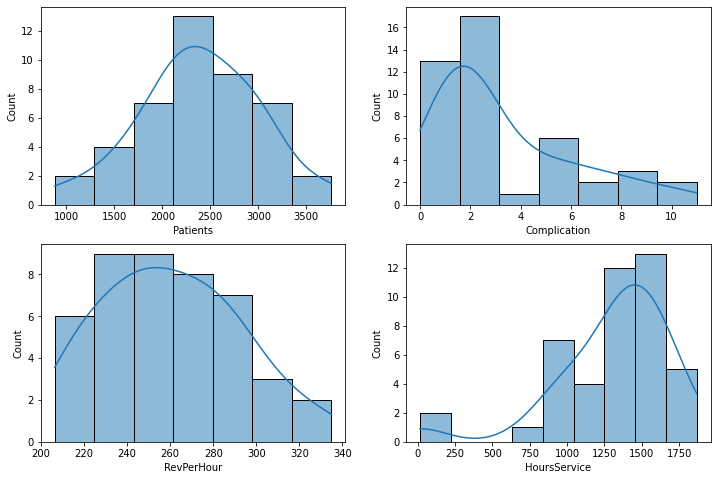

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (12,8))
sns.histplot(complication["Patients"], kde = True, ax = ax[0,0])
sns.histplot(complication["Complication"], kde = True, ax = ax[0,1])
sns.histplot(complication["RevPerHour"], kde = True, ax = ax[1,0])
sns.histplot(complication["HoursService"], kde = True, ax = ax[1,1])
plt.show()

### 6. To evaluate collinearity, check to see if any covariates are correlated.

In [21]:
complication.corr()

,Patients,Complication,Residency,Sex,RevPerHour,HoursService
Patients,1.000000,0.589460,-0.114628,0.188210,0.395629,0.544720
Complication,0.589460,1.000000,0.059030,0.169428,0.155569,0.311744
Residency,-0.114628,0.059030,1.000000,-0.084293,0.110026,-0.097320
Sex,0.188210,0.169428,-0.084293,1.000000,0.180729,0.073943
RevPerHour,0.395629,0.155569,0.110026,0.180729,1.000000,0.059668
HoursService,0.544720,0.311744,-0.097320,0.073943,0.059668,1.000000


*__HoursService__ and __Patients__ has an r = 0.54, which is a moderately positive correlation. __Patients__ and __RevPerHour__ has an r = 0.396, which is very close to a moderate correlation but not yet. It is likely to have collinearity in the model.*

### 7. Fit a Poisson model and interpret the results.

In [22]:
# add intercept column
complication = complication.assign(intercept = 1)

In [23]:
# scale complications by the number of patients
model_poisson = sm.GLM(endog = complication["Complication"], # outcome
                 exog = complication[["intercept", "Residency", "Sex", "RevPerHour", "HoursService"]], # predictors, linear regression part
                 offset = np.log(complication["Patients"]), # log(t)
                 family = sm.families.Poisson(),
)
result_poisson = model_poisson.fit()
result_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           Complication   No. Observations:                   44
Model:                            GLM   Df Residuals:                       39
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90.947
Date:                Tue, 01 Nov 2022   Deviance:                       59.115
Time:                        18:12:39   Pearson chi2:                     63.6
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09347
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -7.1940      0.742     -9.700      0.000      -8.648      -5.740
Residency        0.1629      0.167      0.973      0.331      -0.165       0.491
Sex              0.2147      0.208      1.035      0.301      -0.192       0.622
RevPerHour      -0.0004      0.003     -0.141      0.888      -0.005       0.005
HoursService     0.0003      0.000      1.380      0.168      -0.000       0.001
================================================================================
"""

In [24]:
np.exp(-7.1940), np.exp(-0.0004), np.exp(-0.0004)-1, np.exp(0.2147)

(0.0007510787886889434,
 0.9996000799893344,
 -0.0003999200106655776,
 1.2394899941851785)

*The model would look like this:*  
*log(μ) = log(t) - 7.1940 + 0.1629 __Patients__ + 0.1629 __Residency__ + 0.2147 __Sex__ - 0.0004 __RevPerHour__ + 0.0003 __HoursService__*  
*where log(t) is the offset by the number of patients.*  

*The coefficient for __RevPerHour__ is -0.0004. It means __RevPerHour__ is a protecting factor for complications, which is associated with a reduction of exp(-0.0004) -1 = 0.0004, or 0.04% in the complication rate. Put another way, for one unit increase in the revenue per hour of the ER that evening, complications per patient per night is expected to lower to exp(-0.0004) = 0.9996 times original.*  

*The coefficient for __Sex__ is 0.2147. This means that being male is a risk factor, in which male physicians experience a exp(0.2147) = 1.239 times more complications per patient compared to female physicians, keeping other variables unchanged. It is equivalent to say that rate of complication for male physicians / rate of complication for female physicians = 1.239. Put another way, physicians being male is associated with an increase of 23.9% (1.239 – 1 = 0.239) in the complication rate.*  

*The intercept is -7.1940. It means that exp(-7.1940) = 0.0008 is the predicted mean number of complication per patient per night for female and non-resident when revenue per hour of the ER that evening and number of hours of service the attending physician has had at this ER are 0.*

### 8. Use plots to check the fit and for overdispersion. What do the plots tell you?

In [25]:
from scipy.stats import chi2

critical_value = chi2.ppf(1 - 0.05, df = 4) # alpha = 0.05, DF = 4 (from above fitted model)
print("Pearson chi2 value in statsmodels:", result_poisson.pearson_chi2, 
    "\ncritical value:", critical_value)

Pearson chi2 value in statsmodels: 63.60386491918293 
critical value: 9.487729036781154


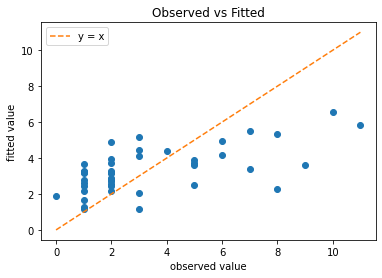

In [26]:
plt.plot(complication["Complication"], result_poisson.fittedvalues, 'o')
plt.plot(complication["Complication"], complication["Complication"], '--', label='y = x')
plt.ylabel("fitted value")
plt.xlabel("observed value")
plt.title("Observed vs Fitted")
plt.legend()
plt.show()

*The deviance test above shows that Pearson chi2 value from statsmodels is much higher than the critical value. It means that the model has poor fit on data. Additionally, looking at the above Observed vs Fitted graph, it does not looks like the trend is well captured by the model line.*

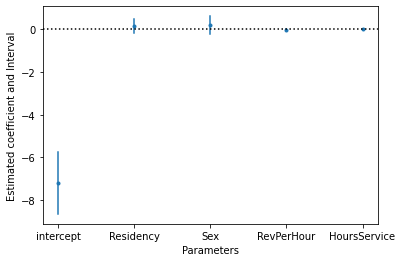

In [27]:
poisson_coefs = result_poisson.params # coefficients
poisson_interval = result_poisson.conf_int().reindex(poisson_coefs.index) # confidence interval

# points for coefficient and short vertical lines for interval
plt.plot(poisson_coefs, '.', color = 'C0') 
for parameter, interval in poisson_interval.iterrows():
    plt.plot([parameter, parameter], interval, color='C0')
    
# y = 0 line to identify significant confidence interval
plt.axhline(y=0, linestyle=':', color='black') 
plt.xticks(poisson_interval.index)

plt.ylabel("Estimated coefficient and Interval")
plt.xlabel("Parameters")
plt.show()

*As the graph indicate, coefficients are not significant.*

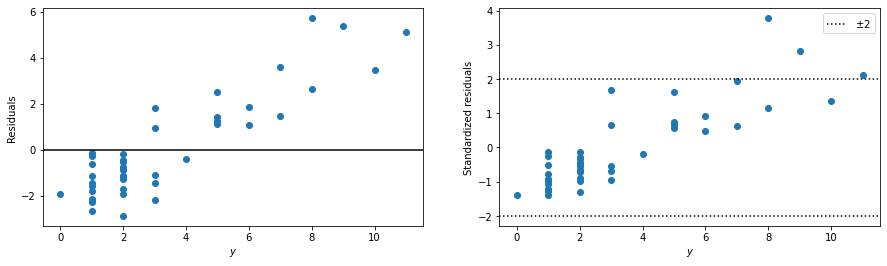

In [28]:
f, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(complication["Complication"], result_poisson.resid_response, 'o')
axes[0].axhline(y=0, linestyle='-', color='black')
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("$y$")


axes[1].plot(complication["Complication"], result_poisson.resid_pearson, 'o')
axes[1].axhline(y=-2, linestyle=':', color='black', label='$\pm 2$')
axes[1].axhline(y=+2, linestyle=':', color='black')
axes[1].set_ylabel("Standardized residuals")
axes[1].set_xlabel("$y$")
plt.legend()
plt.show()

*From the left plot, we can see that there is a trend in which residuals are increasing, as expected. Looking at the right plot, it seems that most points lie inside of the 2 standard deviations area. It suggets that the data is not quite overdisperse.*

In [29]:
# overdispersion ratio R
R = result_poisson.pearson_chi2 / result_poisson.df_resid
print(R)

1.6308683312611008


- *Around 5% of residuals lie outside of the 2-SD area*
- *From model summary: Df Residuals (39) < Deviance (59.115)*    
- *The overdispersion ratio R > 1, but still approximately 1*  

*Therefore, the variance is not so overdispered.*